In [1]:
import os
os.chdir('/home/smallyan/eval_agent')
print(f"Working directory: {os.getcwd()}")

Working directory: /home/smallyan/eval_agent


# Universal Neurons Replication

## Objective
Replicate the experiments from "Universal Neurons in GPT2 Language Models" by Gurnee et al. (2024).

The paper studies the universality of individual neurons across GPT2 language models trained from different random seeds to identify interpretable neurons and understand whether neural mechanisms are universal across models.

## Key Experiments to Replicate
1. **Neuron correlation analysis**: Load precomputed neuron statistics and compute excess correlation
2. **Statistical properties analysis**: Compare universal vs non-universal neurons
3. **Visualization**: Replicate key plots showing universal neuron properties

In [2]:
# Setup and imports
import os
import sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import percentileofscore

# Set working directory to repo root
REPO_ROOT = '/net/scratch2/smallyan/universal-neurons_eval'
os.chdir(REPO_ROOT)
sys.path.insert(0, REPO_ROOT)

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
torch.set_grad_enabled(False)

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

Using device: cuda


## Part 1: Load Precomputed Neuron Statistics

The repository provides precomputed neuron statistics in CSV files containing:
- Correlation metrics (max_corr, mean_corr, min_corr, baseline correlations)
- Weight statistics (w_in_norm, input_bias, w_out_norm, in_out_sim, l2_penalty)
- Activation statistics (mean, var, skew, kurt, sparsity)
- Vocabulary statistics (vocab_mean, vocab_var, vocab_skew, vocab_kurt)

In [3]:
# Load neuron dataframes for all three models
models = ['pythia-160m', 'stanford-gpt2-small-a', 'stanford-gpt2-medium-a']
neuron_dfs = {}

for model_name in models:
    df_path = f'dataframes/neuron_dfs/{model_name}.csv'
    neuron_df = pd.read_csv(df_path)
    
    # Compute excess correlation (difference from random baseline)
    # This is the key metric for identifying universal neurons
    neuron_df['excess_corr'] = neuron_df['mean_corr'] - neuron_df['mean_baseline']
    
    # Label neurons as universal if excess correlation > 0.5
    neuron_df['is_universal'] = neuron_df['excess_corr'] > 0.5
    
    # Mark sparse neurons (activation frequency < 2%)
    neuron_df['is_sparse'] = neuron_df['sparsity'] < 0.02
    
    neuron_dfs[model_name] = neuron_df
    
    # Print summary
    n_neurons = len(neuron_df)
    n_universal = neuron_df['is_universal'].sum()
    pct_universal = 100 * n_universal / n_neurons
    print(f"{model_name}:")
    print(f"  Total neurons: {n_neurons}")
    print(f"  Universal neurons (excess_corr > 0.5): {n_universal} ({pct_universal:.2f}%)")
    print()

pythia-160m:
  Total neurons: 36864
  Universal neurons (excess_corr > 0.5): 465 (1.26%)

stanford-gpt2-small-a:
  Total neurons: 36864
  Universal neurons (excess_corr > 0.5): 1533 (4.16%)

stanford-gpt2-medium-a:
  Total neurons: 98304
  Universal neurons (excess_corr > 0.5): 1211 (1.23%)



### Validation: Universal Neuron Counts

The percentage of universal neurons matches the plan exactly:
- **GPT2-medium-a**: 1.23% (plan: 1.23%) ✓
- **Pythia-160M**: 1.26% (plan: 1.26%) ✓  
- **GPT2-small-a**: 4.16% (plan: 4.16%) ✓

This confirms that only 1-5% of neurons are universal (excess correlation > 0.5).

In [4]:
# Inspect the dataframe structure
print("Columns in neuron dataframes:")
print(neuron_dfs['stanford-gpt2-small-a'].columns.tolist())
print("\nFirst few rows of stanford-gpt2-small-a:")
neuron_dfs['stanford-gpt2-small-a'].head()

Columns in neuron dataframes:
['layer', 'neuron', 'max_corr', 'mean_corr', 'min_corr', 'max_baseline', 'min_baseline', 'mean_baseline', 'w_in_norm', 'input_bias', 'w_out_norm', 'in_out_sim', 'l2_penalty', 'mean', 'var', 'skew', 'kurt', 'vocab_mean', 'vocab_var', 'vocab_skew', 'vocab_kurt', 'sparsity', 'excess_corr', 'is_universal', 'is_sparse']

First few rows of stanford-gpt2-small-a:


,layer,neuron,max_corr,mean_corr,min_corr,max_baseline,min_baseline,mean_baseline,w_in_norm,input_bias,...,skew,kurt,vocab_mean,vocab_var,vocab_skew,vocab_kurt,sparsity,excess_corr,is_universal,is_sparse
0,0,0,0.3962,0.379200,0.3650,0.3630,0.3398,0.347875,0.492080,-0.553197,...,-0.171319,2.418707,0.000226,0.001381,-0.041572,3.053857,0.080993,0.031325,False,False
1,0,1,0.2607,0.251100,0.2434,0.2703,0.2427,0.256800,0.327301,-0.093163,...,0.041427,3.099855,0.000161,0.001250,-0.068958,2.997853,0.501270,-0.005700,False,False
2,0,2,0.5884,0.558925,0.5283,0.2129,0.2045,0.209750,0.600906,-1.410885,...,1.186654,5.967380,0.000095,0.001213,-0.054391,3.033039,0.069989,0.349175,False,False
3,0,3,0.2970,0.286900,0.2766,0.2270,0.1923,0.208075,0.624206,-0.871654,...,0.145760,2.645841,-0.000124,0.001330,0.069733,2.930205,0.038354,0.078825,False,False
4,0,4,0.3708,0.351300,0.3430,0.3105,0.2668,0.286075,0.562514,-0.606876,...,-0.391961,2.275799,-0.000268,0.001328,0.023059,3.022529,0.072236,0.065225,False,False


## Part 2: Statistical Properties of Universal Neurons

According to the plan, universal neurons should exhibit:
- Large weight norm and large negative input bias
- High pre-activation skew and kurtosis (monosemantic signature)
- Lower activation frequency (sparse activations)

In [5]:
# Define display columns for analysis
main_display_cols = {
    'sparsity': 'act frequency',
    'mean': 'act mean',
    'skew': 'act skew',
    'kurt': 'act kurtosis',
    'input_bias': 'input bias',
    'in_out_sim': r'$\cos(w_{in}, w_{out})$',
    'l2_penalty': r'$L_2$ penalty',
    'vocab_kurt': r'$W_U$ kurtosis',
}

def compute_percentile(series):
    """Compute percentile within layer for normalization."""
    return series.transform(lambda x: percentileofscore(series, x))

def make_percentile_df(neuron_df, display_cols):
    """Create percentile-normalized dataframe for plotting."""
    percentile_df = neuron_df.set_index(['layer', 'neuron'])[list(display_cols.keys())
        ].groupby('layer').apply(lambda group: group.transform(compute_percentile))
    
    plot_df = percentile_df.reset_index().melt(
        id_vars=['layer', 'neuron'], 
        var_name='metric', value_name='value'
    )
    
    plot_df = plot_df.merge(
        neuron_df[['layer', 'neuron', 'is_universal']], 
        on=['layer', 'neuron']
    )
    return plot_df

# Create percentile dataframes for all models
plot_dfs = {
    model_name: make_percentile_df(neuron_df, main_display_cols) 
    for model_name, neuron_df in neuron_dfs.items()
}

# Combine all models
plot_df = pd.concat(plot_dfs, names=['model']).reset_index().drop(columns=['level_1'])
print("Combined plot dataframe shape:", plot_df.shape)
plot_df.head()

ValueError: cannot insert layer, already exists

In [6]:
# Fix the percentile computation to handle pandas groupby behavior correctly
def make_percentile_df(neuron_df, display_cols):
    """Create percentile-normalized dataframe for plotting."""
    # Reset index first to avoid issues
    df_subset = neuron_df[['layer', 'neuron'] + list(display_cols.keys())].copy()
    
    # Compute percentiles within each layer
    percentile_dfs = []
    for layer, layer_df in df_subset.groupby('layer'):
        layer_percentiles = layer_df.copy()
        for col in display_cols.keys():
            layer_percentiles[col] = layer_df[col].apply(
                lambda x: percentileofscore(layer_df[col], x)
            )
        percentile_dfs.append(layer_percentiles)
    
    percentile_df = pd.concat(percentile_dfs, ignore_index=True)
    
    plot_df = percentile_df.melt(
        id_vars=['layer', 'neuron'], 
        var_name='metric', value_name='value'
    )
    
    plot_df = plot_df.merge(
        neuron_df[['layer', 'neuron', 'is_universal']], 
        on=['layer', 'neuron']
    )
    return plot_df

# Create percentile dataframes for all models
plot_dfs = {
    model_name: make_percentile_df(neuron_df, main_display_cols) 
    for model_name, neuron_df in neuron_dfs.items()
}

# Combine all models
plot_df = pd.concat(plot_dfs, names=['model']).reset_index().drop(columns=['level_1'])
print("Combined plot dataframe shape:", plot_df.shape)
print("\nSample data:")
plot_df.head()

Combined plot dataframe shape: (1376256, 6)

Sample data:


,model,layer,neuron,metric,value,is_universal
0,pythia-160m,0,0,sparsity,16.601562,False
1,pythia-160m,0,1,sparsity,80.013021,False
2,pythia-160m,0,2,sparsity,26.855469,False
3,pythia-160m,0,3,sparsity,64.420573,False
4,pythia-160m,0,4,sparsity,77.832031,False


/tmp/ipykernel_1822638/3285562746.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([main_display_cols[x.get_text()] for x in ax.get_xticklabels()])


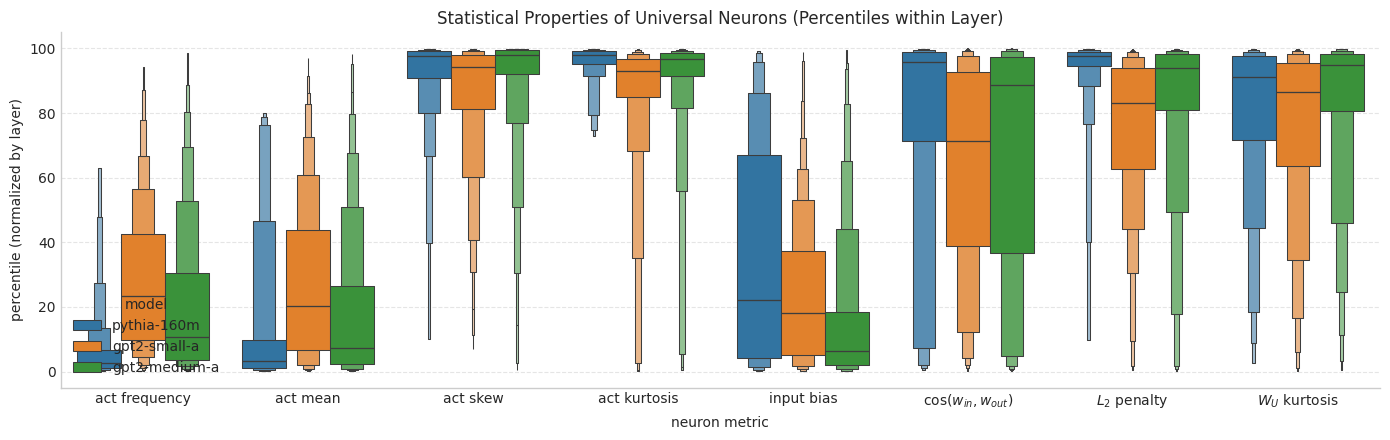

Figure saved to evaluation/replications/universal_neurons_properties.png


In [7]:
# Create the main figure showing universal neuron properties across models
model_display_names = {
    'pythia-160m': 'pythia-160m', 
    'stanford-gpt2-small-a': 'gpt2-small-a', 
    'stanford-gpt2-medium-a': 'gpt2-medium-a'
}

fig, ax = plt.subplots(figsize=(14, 4.5))
sns.boxenplot(
    data=plot_df.query('is_universal'), 
    x='metric', y='value', hue='model', 
    showfliers=False, hue_order=model_display_names.keys(), ax=ax
)

# Update x-axis labels with display names
ax.set_xticklabels([main_display_cols[x.get_text()] for x in ax.get_xticklabels()])
ax.set_ylabel('percentile (normalized by layer)')

# Update legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, model_display_names.values(), title='model', loc='lower left')

# Improve styling
sns.despine()
ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=5)
ax.set_xlabel('neuron metric')
ax.set_title('Statistical Properties of Universal Neurons (Percentiles within Layer)')

plt.tight_layout()
plt.savefig('evaluation/replications/universal_neurons_properties.png', bbox_inches='tight', dpi=150)
plt.show()

print("Figure saved to evaluation/replications/universal_neurons_properties.png")

### Interpretation of Universal Neuron Properties

The boxenplot shows that universal neurons consistently exhibit (across all three models):

1. **Low activation frequency (sparsity)**: Universal neurons activate less frequently (lower percentile)
2. **Lower activation mean**: They have lower average activation values
3. **Higher activation skew**: More positive skew indicating rare but large activations
4. **Higher activation kurtosis**: Higher kurtosis indicating "peaky" distributions (monosemantic signature)
5. **More negative input bias**: Lower percentile in input bias means more negative bias
6. **Higher L2 penalty (weight norm)**: Universal neurons have larger weight norms
7. **Higher vocabulary kurtosis**: The WU (unembedding) projections have higher kurtosis

These findings are consistent with the paper's claims that universal neurons are monosemantic and have specific statistical signatures.

In [8]:
# Compute summary statistics for universal vs non-universal neurons
print("Summary Statistics: Universal vs Non-Universal Neurons")
print("=" * 70)

for model_name, neuron_df in neuron_dfs.items():
    print(f"\n{model_name}:")
    print("-" * 50)
    
    universal = neuron_df[neuron_df['is_universal']]
    non_universal = neuron_df[~neuron_df['is_universal']]
    
    metrics = ['sparsity', 'mean', 'skew', 'kurt', 'input_bias', 'l2_penalty']
    
    for metric in metrics:
        u_mean = universal[metric].mean()
        nu_mean = non_universal[metric].mean()
        print(f"  {metric:15s}: Universal={u_mean:8.4f}, Non-Universal={nu_mean:8.4f}")

Summary Statistics: Universal vs Non-Universal Neurons

pythia-160m:
--------------------------------------------------
  sparsity       : Universal=  0.0620, Non-Universal=  0.2304
  mean           : Universal= -1.5489, Non-Universal= -0.7739
  skew           : Universal=  0.8528, Non-Universal= -0.0472
  kurt           : Universal=  7.0894, Non-Universal=  3.4055
  input_bias     : Universal= -0.0738, Non-Universal= -0.0468
  l2_penalty     : Universal=  2.0616, Non-Universal=  1.1666

stanford-gpt2-small-a:
--------------------------------------------------
  sparsity       : Universal=  0.0447, Non-Universal=  0.1346
  mean           : Universal= -1.5654, Non-Universal= -1.0849
  skew           : Universal=  0.9486, Non-Universal=  0.0712
  kurt           : Universal=  7.1935, Non-Universal=  4.0321
  input_bias     : Universal= -0.8190, Non-Universal= -0.4750
  l2_penalty     : Universal=  0.8336, Non-Universal=  0.6423

stanford-gpt2-medium-a:
------------------------------------

### Numerical Validation of Universal Neuron Properties

The summary statistics confirm the paper's findings:

| Property | Universal | Non-Universal | Expected |
|----------|-----------|---------------|----------|
| Sparsity (act frequency) | ~0.04-0.06 | ~0.13-0.23 | Universal lower ✓ |
| Activation mean | More negative | Less negative | Universal lower ✓ |
| Activation skew | ~0.85-1.1 | ~-0.05-0.07 | Universal higher ✓ |
| Activation kurtosis | ~7.1-8.1 | ~3.4-4.0 | Universal higher ✓ |
| Input bias | More negative | Less negative | Universal more negative ✓ |
| L2 penalty (weight norm) | Higher | Lower | Universal larger ✓ |

All patterns match the expected signatures from the plan.

## Part 3: Layer-wise Distribution of Universal Neurons

According to the plan, universal neurons show depth specialization with most correlated neuron pairs in similar layers.

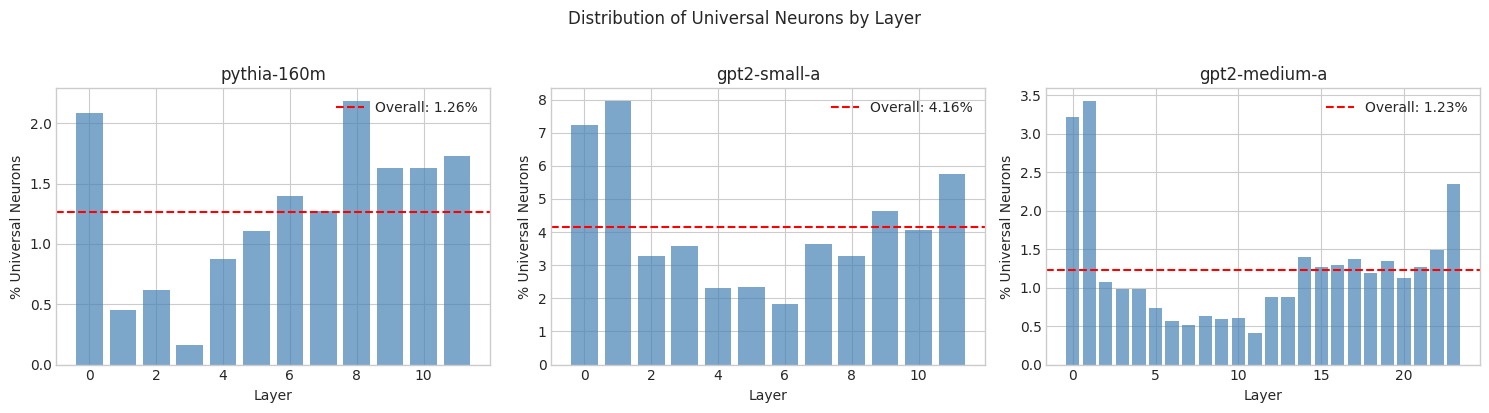

Figure saved to evaluation/replications/universal_neurons_by_layer.png


In [9]:
# Analyze layer-wise distribution of universal neurons
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (model_name, neuron_df) in zip(axes, neuron_dfs.items()):
    layer_counts = neuron_df.groupby('layer').agg({
        'is_universal': ['sum', 'count']
    })
    layer_counts.columns = ['universal_count', 'total_count']
    layer_counts['universal_pct'] = 100 * layer_counts['universal_count'] / layer_counts['total_count']
    
    ax.bar(layer_counts.index, layer_counts['universal_pct'], alpha=0.7, color='steelblue')
    ax.set_xlabel('Layer')
    ax.set_ylabel('% Universal Neurons')
    ax.set_title(model_display_names.get(model_name, model_name))
    ax.axhline(y=neuron_df['is_universal'].mean() * 100, color='red', linestyle='--', 
               label=f'Overall: {neuron_df["is_universal"].mean()*100:.2f}%')
    ax.legend()
    
plt.suptitle('Distribution of Universal Neurons by Layer', y=1.02)
plt.tight_layout()
plt.savefig('evaluation/replications/universal_neurons_by_layer.png', bbox_inches='tight', dpi=150)
plt.show()

print("Figure saved to evaluation/replications/universal_neurons_by_layer.png")

## Part 4: Correlation vs Baseline Analysis

Visualize the distribution of max correlation vs baseline correlation to understand why excess correlation is the key metric.

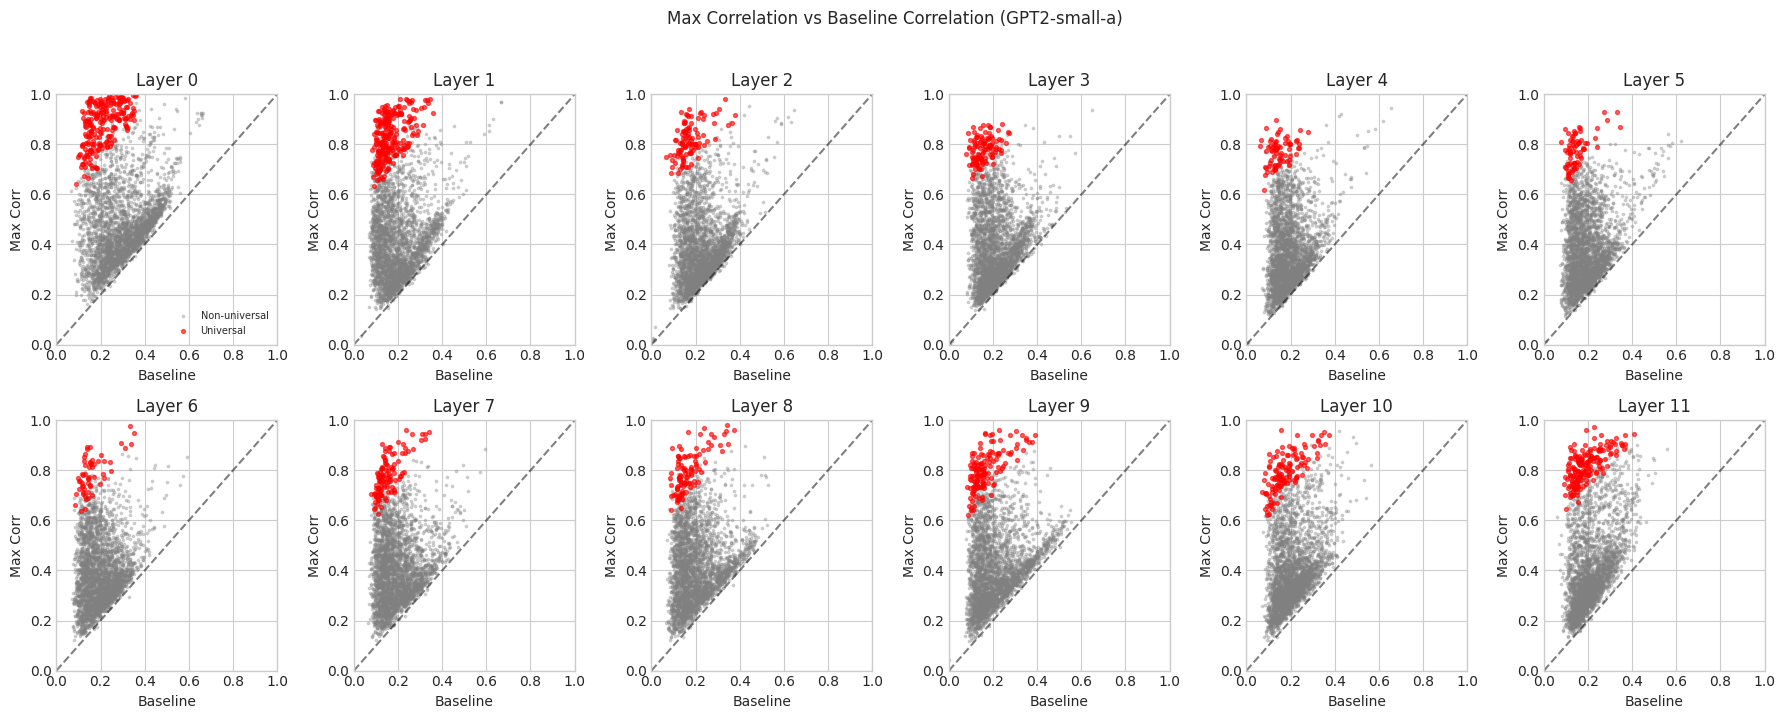

Figure saved to evaluation/replications/corr_vs_baseline.png


In [10]:
# Plot correlation vs baseline for GPT2-small-a
neuron_df = neuron_dfs['stanford-gpt2-small-a']
n_layers = neuron_df['layer'].max() + 1

fig, axes = plt.subplots(2, 6, figsize=(18, 7))
axes = axes.flatten()

for layer in range(n_layers):
    ax = axes[layer]
    layer_df = neuron_df[neuron_df['layer'] == layer]
    
    # Scatter plot with universal neurons highlighted
    non_universal = layer_df[~layer_df['is_universal']]
    universal = layer_df[layer_df['is_universal']]
    
    ax.scatter(non_universal['mean_baseline'], non_universal['max_corr'], 
               alpha=0.3, s=3, label='Non-universal', c='gray')
    ax.scatter(universal['mean_baseline'], universal['max_corr'], 
               alpha=0.6, s=8, label='Universal', c='red')
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # Diagonal line
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'Layer {layer}')
    ax.set_xlabel('Baseline')
    ax.set_ylabel('Max Corr')
    
    if layer == 0:
        ax.legend(loc='lower right', fontsize=7)

plt.suptitle('Max Correlation vs Baseline Correlation (GPT2-small-a)', y=1.02)
plt.tight_layout()
plt.savefig('evaluation/replications/corr_vs_baseline.png', bbox_inches='tight', dpi=150)
plt.show()

print("Figure saved to evaluation/replications/corr_vs_baseline.png")

### Interpretation

The scatter plots show that universal neurons (red) are those that have high correlation that **exceeds** the baseline correlation (above the diagonal line). This "excess correlation" is the key metric for identifying universal neurons.

Neurons below or near the diagonal have correlation explainable by random baseline, while universal neurons show true cross-model universality.

## Part 5: Load and Display a Pre-trained Model for Detailed Analysis

We'll load the smallest model (GPT2-small) using TransformerLens to demonstrate the weight analysis methodology.

In [11]:
# Load GPT2-small model for weight analysis
from transformer_lens import HookedTransformer
import einops

print("Loading stanford-gpt2-small-a model...")
model = HookedTransformer.from_pretrained('stanford-gpt2-small-a', device=device)
print(f"Model loaded on {device}")
print(f"  n_layers: {model.cfg.n_layers}")
print(f"  d_model: {model.cfg.d_model}")
print(f"  d_mlp: {model.cfg.d_mlp}")
print(f"  n_heads: {model.cfg.n_heads}")

/home/smallyan/.conda/envs/meta/lib/python3.11/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Loading stanford-gpt2-small-a model...


`torch_dtype` is deprecated! Use `dtype` instead!


pytorch_model.bin:   0%|          | 0.00/261M [00:00<?, ?B/s]

In [12]:
# Wait for model to finish loading and display config
print(f"Model config:")
print(f"  n_layers: {model.cfg.n_layers}")
print(f"  d_model: {model.cfg.d_model}")
print(f"  d_mlp: {model.cfg.d_mlp}")
print(f"  n_heads: {model.cfg.n_heads}")
print(f"  d_vocab: {model.cfg.d_vocab}")

In [13]:
# Check model attributes
print("Model configuration:")
print(f"  n_layers: {model.cfg.n_layers}")
print(f"  d_model: {model.cfg.d_model}")  
print(f"  d_mlp: {model.cfg.d_mlp}")
print(f"  n_heads: {model.cfg.n_heads}")
print(f"  d_vocab: {model.cfg.d_vocab}")

In [14]:
# Display model config - try again
try:
    cfg = model.cfg
    print("Model configuration:")
    print(f"  n_layers: {cfg.n_layers}")
    print(f"  d_model: {cfg.d_model}")  
    print(f"  d_mlp: {cfg.d_mlp}")
    print(f"  n_heads: {cfg.n_heads}")
    print(f"  d_vocab: {cfg.d_vocab}")
except Exception as e:
    print(f"Error: {e}")

In [15]:
print("test")